1. Get crv emissions per pool.
2. Get fees claimed per pool.
3. divide the two to get swap revenue per crv emitted per gauge.

In [1]:
# subgraph querying modules
import datetime
import calendar

import requests

In [57]:
# plotting tools
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import seaborn as sns
sns.set_style("whitegrid")

In [3]:
# brownie
import os
import sys
sys.path.append("../../")

import brownie

from utils.contract_utils import init_contract
from utils.network_utils import configure_network_and_connect
from utils.eth_blocks_utils import get_block_for_timestamp


In [4]:
ALCHEMY_API_KEY = os.environ['ALCHEMY_API_KEY']
configure_network_and_connect(
    node_provider_https=f"https://eth-mainnet.alchemyapi.io/v2/{ALCHEMY_API_KEY}",
    network_name='mainnet'
)

# Pools and Gauges

Get dict of pools (keys) and gauge (value)

In [5]:
ethereum_registry_contract = init_contract("0x90E00ACe148ca3b23Ac1bC8C240C2a7Dd9c2d7f5")
ethereum_registry_contract.info()

  @title Curve Registry
  @author Curve.Fi



Get pools and gauges:

In [10]:
pool_count = ethereum_registry_contract.pool_count()
eth_pools_and_gauges = {}
for pool_id in range(pool_count):

    pool_addr = ethereum_registry_contract.pool_list(pool_id)
    gauge_addr = ethereum_registry_contract.get_gauges(pool_addr)
    lp_token_addr = ethereum_registry_contract.get_lp_token(pool_addr)

    # get lp_token name:
    pool_token_contract = init_contract(lp_token_addr)
    pool_token_name = pool_token_contract.name()

    eth_pools_and_gauges[pool_addr] = [gauge_addr[0][0], lp_token_addr, pool_token_name]

eth_pools_and_gauges

Fetching source of 0x6c3F90f043a72FA612cbac8115EE7e52BDe6E490 from api.etherscan.io...
Fetching source of 0xFd2a8fA60Abd58Efe3EeE34dd494cD491dC14900 from api.etherscan.io...
Fetching source of 0xaA17A236F2bAdc98DDc0Cf999AbB47D47Fc0A6Cf from api.etherscan.io...
Fetching source of 0x3B3Ac5386837Dc563660FB6a0937DFAa5924333B from api.etherscan.io...
Fetching source of 0x845838DF265Dcd2c412A1Dc9e959c7d08537f8a2 from api.etherscan.io...
Fetching source of 0x194eBd173F6cDacE046C53eACcE9B953F28411d1 from api.etherscan.io...
Fetching source of 0xb19059ebb43466C323583928285a49f558E572Fd from api.etherscan.io...
Fetching source of 0x5282a4eF67D9C33135340fB3289cc1711c13638C from api.etherscan.io...
Fetching source of 0xcee60cFa923170e4f8204AE08B4fA6A3F5656F3a from api.etherscan.io...
Fetching source of 0xD905e2eaeBe188fc92179b6350807D8bd91Db0D8 from api.etherscan.io...
Fetching source of 0x49849C98ae39Fff122806C06791Fa73784FB3675 from api.etherscan.io...
Fetching source of 0x02d341CcB60fAaf662bC05

{'0xbEbc44782C7dB0a1A60Cb6fe97d0b483032FF1C7': ['0xbFcF63294aD7105dEa65aA58F8AE5BE2D9d0952A',
  '0x6c3F90f043a72FA612cbac8115EE7e52BDe6E490',
  'Curve.fi DAI/USDC/USDT'],
 '0xDeBF20617708857ebe4F679508E7b7863a8A8EeE': ['0xd662908ADA2Ea1916B3318327A97eB18aD588b5d',
  '0xFd2a8fA60Abd58Efe3EeE34dd494cD491dC14900',
  'Curve.fi aDAI/aUSDC/aUSDT'],
 '0xA96A65c051bF88B4095Ee1f2451C2A9d43F53Ae2': ['0x6d10ed2cF043E6fcf51A0e7b4C2Af3Fa06695707',
  '0xaA17A236F2bAdc98DDc0Cf999AbB47D47Fc0A6Cf',
  'Curve.fi ETH/aETH'],
 '0x79a8C46DeA5aDa233ABaFFD40F3A0A2B1e5A4F27': ['0x69Fb7c45726cfE2baDeE8317005d3F94bE838840',
  '0x3B3Ac5386837Dc563660FB6a0937DFAa5924333B',
  'Curve.fi yDAI/yUSDC/yUSDT/yBUSD'],
 '0xA2B47E3D5c44877cca798226B7B8118F9BFb7A56': ['0x7ca5b0a2910B33e9759DC7dDB0413949071D7575',
  '0x845838DF265Dcd2c412A1Dc9e959c7d08537f8a2',
  'Curve.fi cDAI/cUSDC'],
 '0x0Ce6a5fF5217e38315f87032CF90686C96627CAA': ['0x90Bb609649E0451E5aD952683D64BD2d1f245840',
  '0x194eBd173F6cDacE046C53eACcE9B953F28411d1',

# CRV emissions per pool:

In [11]:
crv_token_addr = "0xD533a949740bb3306d119CC777fa900bA034cd52"
crv_token = init_contract(crv_token_addr)
crv_token.info()

  @title Curve DAO Token
  @notice ERC20 with piecewise-linear mining supply.
  @author Curve Finance
  @details Based on the ERC-20 token standard as defined
           at https://eips.ethereum.org/EIPS/eip-20



CRV emissions rate per block

In [12]:
crv_token.rate() * 1e-18

7.327853447857532

get number of blocks between two timestamps:

In [13]:
block_time_start = int(
    calendar.timegm((datetime.datetime.now() - datetime.timedelta(days=7)).date().timetuple())
)
block_time_end = int(
    calendar.timegm((datetime.datetime.now()).date().timetuple())
)
crv_token.mintable_in_timeframe(block_time_start, block_time_end) * 1e-18

4431885.7652642345

get gauge weights from registry for block:

In [14]:
gauge_controller_address = "0x2F50D538606Fa9EDD2B11E2446BEb18C9D5846bB"
gauge_controller = init_contract(gauge_controller_address)
gauge_controller.info()

  @title Gauge Controller
  @notice Controls liquidity gauges and the issuance of
          coins through the gauges
  @author Curve Finance



Get crv emitted for gauge

In [15]:
time_start = int(datetime.datetime.strptime("2021-09-01", "%Y-%m-%d").timestamp())
time_end = int(datetime.datetime.strptime("2021-10-01", "%Y-%m-%d").timestamp())
delta_time = int(datetime.timedelta(days=1).total_seconds())
date_range = list(range(time_start,time_end,delta_time))

In [51]:
emissions_data = pd.DataFrame()
for timestamp in date_range:

    block_number = get_block_for_timestamp(timestamp=timestamp)

    with brownie.multicall(block_identifier=block_number):

        for pool_addr, pool_details in eth_pools_and_gauges.items():

            pool_data = {}

            gauge_addr = pool_details[0]
            lp_token_addr = pool_details[1]
            pool_name = pool_details[2]

            # get crv emissions for timestamp from the past day:
            crv_minted = crv_token.mintable_in_timeframe(
                int(timestamp - delta_time),
                timestamp
            ) * 1e-18

            # get gauge relative weight
            gauge_relative_weight = gauge_controller.gauge_relative_weight(gauge_addr) * 1e-18

            # get virtual price:
            try:
                lp_token_virtual_price = (
                    ethereum_registry_contract.get_virtual_price_from_lp_token(lp_token_addr)
                ) * 1e-18
            except TypeError:
                lp_token = init_contract(lp_token_addr)
                lp_token_virtual_price = lp_token.get_virtual_price() * 1e-18

            # get total supply of lp_token:
            lp_token = init_contract(lp_token_addr)
            total_supply_lp_token = lp_token.totalSupply() * 1e-18

            # pool data
            pool_data['timestamp'] = timestamp
            pool_data['block_number'] = block_number
            pool_data['pool_name'] = pool_name
            pool_data['pool_addr'] = pool_addr
            pool_data['lp_token_addr'] = lp_token_addr
            pool_data['gauge_addr'] = gauge_addr
            pool_data['gauge_relative_weight'] = gauge_relative_weight
            pool_data['lp_token_virtual_price'] = lp_token_virtual_price
            pool_data['total_supply_lp_token'] = total_supply_lp_token
            pool_data['crv_minted_past_1d'] = crv_minted
            pool_data['crv_to_gauge'] = gauge_relative_weight * crv_minted

            pool_data = pd.DataFrame(
                data=pool_data,
                index=[pd.to_datetime(pool_data['timestamp'], unit='s')]
            )

            # join df
            emissions_data = pd.concat([emissions_data, pool_data])


In [52]:
emissions_data

,timestamp,block_number,pool_name,pool_addr,lp_token_addr,gauge_addr,gauge_relative_weight,lp_token_virtual_price,total_supply_lp_token,crv_minted_past_1d,crv_to_gauge
2021-08-31 22:00:00,1630447200,13135896,Curve.fi DAI/USDC/USDT,0xbEbc44782C7dB0a1A60Cb6fe97d0b483032FF1C7,0x6c3F90f043a72FA612cbac8115EE7e52BDe6E490,0xbFcF63294aD7105dEa65aA58F8AE5BE2D9d0952A,0.021880,1.018685,1.286472e+09,633126.537895,13852.744714
2021-08-31 22:00:00,1630447200,13135896,Curve.fi aDAI/aUSDC/aUSDT,0xDeBF20617708857ebe4F679508E7b7863a8A8EeE,0xFd2a8fA60Abd58Efe3EeE34dd494cD491dC14900,0xd662908ADA2Ea1916B3318327A97eB18aD588b5d,0.010496,1.063614,1.564598e+08,633126.537895,6645.210163
2021-08-31 22:00:00,1630447200,13135896,Curve.fi ETH/aETH,0xA96A65c051bF88B4095Ee1f2451C2A9d43F53Ae2,0xaA17A236F2bAdc98DDc0Cf999AbB47D47Fc0A6Cf,0x6d10ed2cF043E6fcf51A0e7b4C2Af3Fa06695707,0.001276,1.022457,1.614920e+04,633126.537895,807.561209
2021-08-31 22:00:00,1630447200,13135896,Curve.fi yDAI/yUSDC/yUSDT/yBUSD,0x79a8C46DeA5aDa233ABaFFD40F3A0A2B1e5A4F27,0x3B3Ac5386837Dc563660FB6a0937DFAa5924333B,0x69Fb7c45726cfE2baDeE8317005d3F94bE838840,0.003480,1.119991,3.099509e+07,633126.537895,2203.474298
2021-08-31 22:00:00,1630447200,13135896,Curve.fi cDAI/cUSDC,0xA2B47E3D5c44877cca798226B7B8118F9BFb7A56,0x845838DF265Dcd2c412A1Dc9e959c7d08537f8a2,0x7ca5b0a2910B33e9759DC7dDB0413949071D7575,0.012873,1.083043,1.542350e+08,633126.537895,8150.517794
...,...,...,...,...,...,...,...,...,...,...,...
2021-09-29 22:00:00,1632952800,13323244,Curve.fi Factory USD Metapool: Alchemix USD,0x43b4FdFD4Ff969587185cDB6f0BD875c5Fc83f8c,0x43b4FdFD4Ff969587185cDB6f0BD875c5Fc83f8c,0x9582C4ADACB3BCE56Fea3e590F05c3ca2fb9C477,0.047874,1.006972,4.349596e+08,633126.537895,30310.511978
2021-09-29 22:00:00,1632952800,13323244,Curve.fi USD-BTC-ETH,0x80466c64868E1ab14a1Ddf27A676C3fcBE638Fe5,0xcA3d75aC011BF5aD07a98d02f18225F9bD9A6BDF,0x6955a55416a06839309018A8B0cB72c4DDC11f15,0.002235,1.010262,1.362237e+04,633126.537895,1415.104429
2021-09-29 22:00:00,1632952800,13323244,Curve.fi USD-BTC-ETH,0xD51a44d3FaE010294C616388b506AcdA1bfAAE46,0xc4AD29ba4B3c580e6D59105FFf484999997675Ff,0xDeFd8FdD20e0f34115C7018CCfb655796F6B2168,0.116800,1.004559,3.634288e+05,633126.537895,73949.480271
2021-09-29 22:00:00,1632952800,13323244,Curve.fi Factory USD Metapool: Magic Internet ...,0x5a6A4D54456819380173272A5E8E9B9904BdF41B,0x5a6A4D54456819380173272A5E8E9B9904BdF41B,0xd8b712d29381748dB89c36BCa0138d7c75866ddF,0.192768,1.002439,9.355905e+08,633126.537895,122046.744497


# swap fees to liquidity providers per pool per week:

In [53]:
emissions_and_revenue = emissions_data.copy()
emissions_and_revenue

,timestamp,block_number,pool_name,pool_addr,lp_token_addr,gauge_addr,gauge_relative_weight,lp_token_virtual_price,total_supply_lp_token,crv_minted_past_1d,crv_to_gauge
2021-08-31 22:00:00,1630447200,13135896,Curve.fi DAI/USDC/USDT,0xbEbc44782C7dB0a1A60Cb6fe97d0b483032FF1C7,0x6c3F90f043a72FA612cbac8115EE7e52BDe6E490,0xbFcF63294aD7105dEa65aA58F8AE5BE2D9d0952A,0.021880,1.018685,1.286472e+09,633126.537895,13852.744714
2021-08-31 22:00:00,1630447200,13135896,Curve.fi aDAI/aUSDC/aUSDT,0xDeBF20617708857ebe4F679508E7b7863a8A8EeE,0xFd2a8fA60Abd58Efe3EeE34dd494cD491dC14900,0xd662908ADA2Ea1916B3318327A97eB18aD588b5d,0.010496,1.063614,1.564598e+08,633126.537895,6645.210163
2021-08-31 22:00:00,1630447200,13135896,Curve.fi ETH/aETH,0xA96A65c051bF88B4095Ee1f2451C2A9d43F53Ae2,0xaA17A236F2bAdc98DDc0Cf999AbB47D47Fc0A6Cf,0x6d10ed2cF043E6fcf51A0e7b4C2Af3Fa06695707,0.001276,1.022457,1.614920e+04,633126.537895,807.561209
2021-08-31 22:00:00,1630447200,13135896,Curve.fi yDAI/yUSDC/yUSDT/yBUSD,0x79a8C46DeA5aDa233ABaFFD40F3A0A2B1e5A4F27,0x3B3Ac5386837Dc563660FB6a0937DFAa5924333B,0x69Fb7c45726cfE2baDeE8317005d3F94bE838840,0.003480,1.119991,3.099509e+07,633126.537895,2203.474298
2021-08-31 22:00:00,1630447200,13135896,Curve.fi cDAI/cUSDC,0xA2B47E3D5c44877cca798226B7B8118F9BFb7A56,0x845838DF265Dcd2c412A1Dc9e959c7d08537f8a2,0x7ca5b0a2910B33e9759DC7dDB0413949071D7575,0.012873,1.083043,1.542350e+08,633126.537895,8150.517794
...,...,...,...,...,...,...,...,...,...,...,...
2021-09-29 22:00:00,1632952800,13323244,Curve.fi Factory USD Metapool: Alchemix USD,0x43b4FdFD4Ff969587185cDB6f0BD875c5Fc83f8c,0x43b4FdFD4Ff969587185cDB6f0BD875c5Fc83f8c,0x9582C4ADACB3BCE56Fea3e590F05c3ca2fb9C477,0.047874,1.006972,4.349596e+08,633126.537895,30310.511978
2021-09-29 22:00:00,1632952800,13323244,Curve.fi USD-BTC-ETH,0x80466c64868E1ab14a1Ddf27A676C3fcBE638Fe5,0xcA3d75aC011BF5aD07a98d02f18225F9bD9A6BDF,0x6955a55416a06839309018A8B0cB72c4DDC11f15,0.002235,1.010262,1.362237e+04,633126.537895,1415.104429
2021-09-29 22:00:00,1632952800,13323244,Curve.fi USD-BTC-ETH,0xD51a44d3FaE010294C616388b506AcdA1bfAAE46,0xc4AD29ba4B3c580e6D59105FFf484999997675Ff,0xDeFd8FdD20e0f34115C7018CCfb655796F6B2168,0.116800,1.004559,3.634288e+05,633126.537895,73949.480271
2021-09-29 22:00:00,1632952800,13323244,Curve.fi Factory USD Metapool: Magic Internet ...,0x5a6A4D54456819380173272A5E8E9B9904BdF41B,0x5a6A4D54456819380173272A5E8E9B9904BdF41B,0xd8b712d29381748dB89c36BCa0138d7c75866ddF,0.192768,1.002439,9.355905e+08,633126.537895,122046.744497


In [54]:
for pool_name in emissions_and_revenue.pool_name.unique():

    pool_data = emissions_and_revenue[emissions_and_revenue.pool_name == pool_name]

    break

In [60]:
pool_data['virtual_price_diff'] = pool_data.lp_token_virtual_price.diff()
pool_data['swap_fee_revenue'] = pool_data.virtual_price_diff * pool_data.total_supply_lp_token * 2
pool_data['swap_revenue_to_crv_emissions_ratio'] = pool_data.swap_fee_revenue / pool_data.crv_to_gauge
pool_data

,timestamp,block_number,pool_name,pool_addr,lp_token_addr,gauge_addr,gauge_relative_weight,lp_token_virtual_price,total_supply_lp_token,crv_minted_past_1d,crv_to_gauge,virtual_price_diff,swap_fee_revenue,swap_revenue_to_crv_emissions_ratio
2021-08-31 22:00:00,1630447200,13135896,Curve.fi DAI/USDC/USDT,0xbEbc44782C7dB0a1A60Cb6fe97d0b483032FF1C7,0x6c3F90f043a72FA612cbac8115EE7e52BDe6E490,0xbFcF63294aD7105dEa65aA58F8AE5BE2D9d0952A,0.021880,1.018685,1.286472e+09,633126.537895,13852.744714,NaN,NaN,NaN
2021-09-01 22:00:00,1630533600,13142319,Curve.fi DAI/USDC/USDT,0xbEbc44782C7dB0a1A60Cb6fe97d0b483032FF1C7,0x6c3F90f043a72FA612cbac8115EE7e52BDe6E490,0xbFcF63294aD7105dEa65aA58F8AE5BE2D9d0952A,0.021880,1.018698,1.336808e+09,633126.537895,13852.744714,0.000013,34485.777420,2.489454
2021-09-02 22:00:00,1630620000,13148889,Curve.fi DAI/USDC/USDT,0xbEbc44782C7dB0a1A60Cb6fe97d0b483032FF1C7,0x6c3F90f043a72FA612cbac8115EE7e52BDe6E490,0xbFcF63294aD7105dEa65aA58F8AE5BE2D9d0952A,0.020864,1.018721,1.375188e+09,633126.537895,13209.650444,0.000023,62486.620104,4.730377
2021-09-03 22:00:00,1630706400,13155329,Curve.fi DAI/USDC/USDT,0xbEbc44782C7dB0a1A60Cb6fe97d0b483032FF1C7,0x6c3F90f043a72FA612cbac8115EE7e52BDe6E490,0xbFcF63294aD7105dEa65aA58F8AE5BE2D9d0952A,0.020864,1.018732,1.370109e+09,633126.537895,13209.650444,0.000011,29722.303916,2.250045
2021-09-04 22:00:00,1630792800,13161797,Curve.fi DAI/USDC/USDT,0xbEbc44782C7dB0a1A60Cb6fe97d0b483032FF1C7,0x6c3F90f043a72FA612cbac8115EE7e52BDe6E490,0xbFcF63294aD7105dEa65aA58F8AE5BE2D9d0952A,0.020864,1.018739,1.382858e+09,633126.537895,13209.650444,0.000007,20343.606198,1.540056
2021-09-05 22:00:00,1630879200,13168274,Curve.fi DAI/USDC/USDT,0xbEbc44782C7dB0a1A60Cb6fe97d0b483032FF1C7,0x6c3F90f043a72FA612cbac8115EE7e52BDe6E490,0xbFcF63294aD7105dEa65aA58F8AE5BE2D9d0952A,0.020864,1.018746,1.391266e+09,633126.537895,13209.650444,0.000007,19900.337326,1.506500
2021-09-06 22:00:00,1630965600,13174740,Curve.fi DAI/USDC/USDT,0xbEbc44782C7dB0a1A60Cb6fe97d0b483032FF1C7,0x6c3F90f043a72FA612cbac8115EE7e52BDe6E490,0xbFcF63294aD7105dEa65aA58F8AE5BE2D9d0952A,0.020864,1.018756,1.422362e+09,633126.537895,13209.650444,0.000010,28112.539589,2.128182
2021-09-07 22:00:00,1631052000,13181214,Curve.fi DAI/USDC/USDT,0xbEbc44782C7dB0a1A60Cb6fe97d0b483032FF1C7,0x6c3F90f043a72FA612cbac8115EE7e52BDe6E490,0xbFcF63294aD7105dEa65aA58F8AE5BE2D9d0952A,0.020864,1.018780,1.413572e+09,633126.537895,13209.650444,0.000024,67682.726582,5.123733
2021-09-08 22:00:00,1631138400,13187688,Curve.fi DAI/USDC/USDT,0xbEbc44782C7dB0a1A60Cb6fe97d0b483032FF1C7,0x6c3F90f043a72FA612cbac8115EE7e52BDe6E490,0xbFcF63294aD7105dEa65aA58F8AE5BE2D9d0952A,0.020864,1.018799,1.443852e+09,633126.537895,13209.650444,0.000019,53431.034093,4.044848
2021-09-09 22:00:00,1631224800,13194159,Curve.fi DAI/USDC/USDT,0xbEbc44782C7dB0a1A60Cb6fe97d0b483032FF1C7,0x6c3F90f043a72FA612cbac8115EE7e52BDe6E490,0xbFcF63294aD7105dEa65aA58F8AE5BE2D9d0952A,0.039900,1.018811,1.489629e+09,633126.537895,25261.632149,0.000012,36906.809226,1.460983


# plots:

In [61]:
df_plot = pool_data.dropna()

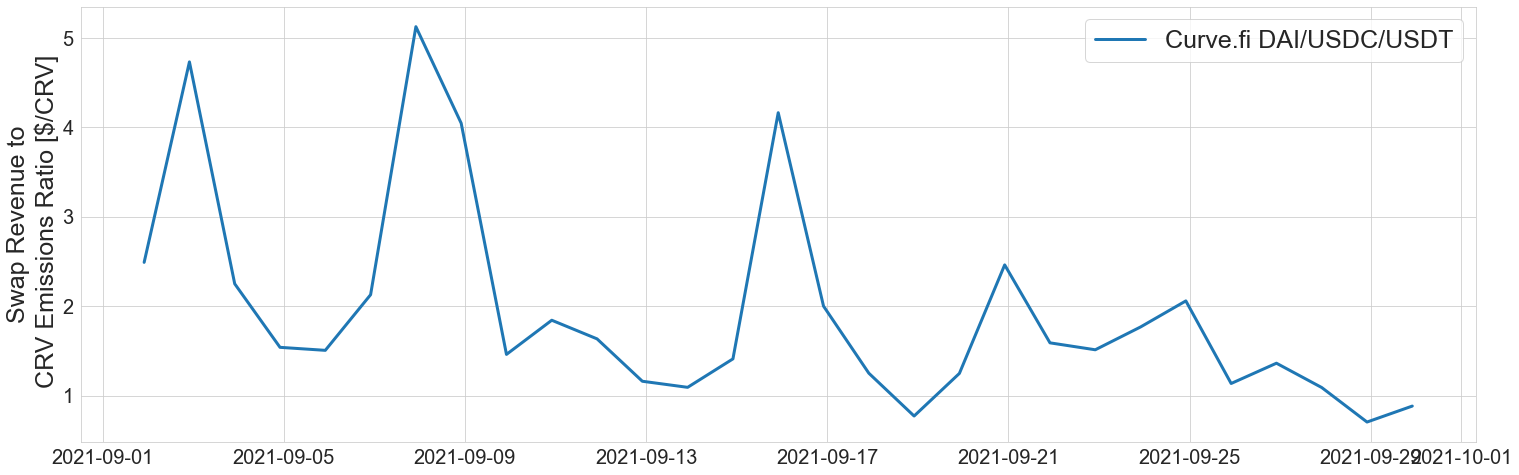

In [67]:
fig, ax = plt.subplots(1,1, figsize=(25, 8))

ax.plot(
    df_plot.index,
    df_plot.swap_revenue_to_crv_emissions_ratio,
    label=df_plot.pool_name.unique()[0],
    lw=3
)

ax.set_ylabel("Swap Revenue to\n CRV Emissions Ratio [$/CRV]", fontsize=25)
ax.set_xlabel("", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.legend(fontsize=25);